<a href="https://colab.research.google.com/github/EinarRomero/Modulo-2-Modelos-Estadisticos/blob/main/Series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EJERCICIO 1

##IMPORTAR LIBRERIAS

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import statsmodels.tsa.arima.model
import sklearn as sk
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from google.colab import autoviz
from google.colab import drive
import xlrd

from matplotlib.ticker import PercentFormatter


##OBTENER EL DATA FRAME

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dfme=pd.read_excel('/content/drive/MyDrive/MODULO 3 TIME SERIES/Tasa de vida y muerte.csv (1).xlsx')
dfme

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
0,1900,All Races,Both Sexes,47.3,2518.0
1,1901,All Races,Both Sexes,49.1,2473.1
2,1902,All Races,Both Sexes,51.5,2301.3
3,1903,All Races,Both Sexes,50.5,2379.0
4,1904,All Races,Both Sexes,47.6,2502.5
...,...,...,...,...,...
1066,2014,White,Male,76.7,853.4
1067,2015,White,Male,76.6,861.9
1068,2016,White,Male,76.4,858.9
1069,2017,White,Male,76.4,863.4


In [4]:
dfme.dtypes

,0
Year,int64
Race,object
Sex,object
Average Life Expectancy (Years),float64
Age-adjusted Death Rate,float64


Notemos que python entiende a la columna Year como flotante de 64 bits así como Average Life Expectancy (Years)	y Age-adjusted Death Rate, las columnas Race, Sex como objeto, cambiemos el formato a fecha (year).

Las buenas prácticas en modelado de series de tiempo indican tener formato en año-mes-día, y notando que los datos son anuales, se asume que se está tomando el último día de cada año dado que es la observación que contiene toda la información para las tasas de vida o muerte de todo el año transcurrido, (es por ello que no se toma el primer día, porque no explica el comportamiento del año transcurrido).


Para términos prácticos convertimos la columna "Year" a tipo fecha y por términos de zonas horarias python toma el mes y día como el primer día del año, pero nosotros entendemos a esa fecha como el último día (Por buenas prácticas).

In [5]:
# Convertir 'Year' a datetime y establecerlo como índice
dfme['Year'] = pd.to_datetime(dfme['Year'], format='%Y')
dfme.set_index('Year', inplace=True)

DataFrame con el formato fecha y establecido como índice.

In [6]:
dfme

,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
Year,,,,
1900-01-01,All Races,Both Sexes,47.3,2518.0
1901-01-01,All Races,Both Sexes,49.1,2473.1
1902-01-01,All Races,Both Sexes,51.5,2301.3
1903-01-01,All Races,Both Sexes,50.5,2379.0
1904-01-01,All Races,Both Sexes,47.6,2502.5
...,...,...,...,...
2014-01-01,White,Male,76.7,853.4
2015-01-01,White,Male,76.6,861.9
2016-01-01,White,Male,76.4,858.9


##Primer Modelo: Esperanza de Vida de las Mujeres en EU (raza sin importancia)

In [7]:
dfme.columns

Index(['Race', 'Sex', 'Average Life Expectancy (Years)',
       'Age-adjusted Death Rate'],
      dtype='object')

In [8]:
#Mostrar los valores únicos de la columna "Sex"
valores_unicos = dfme['Sex'].unique()

print(valores_unicos)

['Both Sexes' 'Female' 'Male']


Acotamos nuestra serie de tiempo como la esperanza de vida de las mujeres en EU sin importar la raza.

In [9]:
df=dfme[(dfme['Sex'] == 'Both Sexes')&(dfme['Race'] == 'All Races')]
df=df[['Average Life Expectancy (Years)']]
df

,Average Life Expectancy (Years)
Year,
1900-01-01,47.3
1901-01-01,49.1
1902-01-01,51.5
1903-01-01,50.5
1904-01-01,47.6
...,...
2014-01-01,78.9
2015-01-01,78.7
2016-01-01,78.7


###Análisis Exploratorio de la Serie de Tiempo

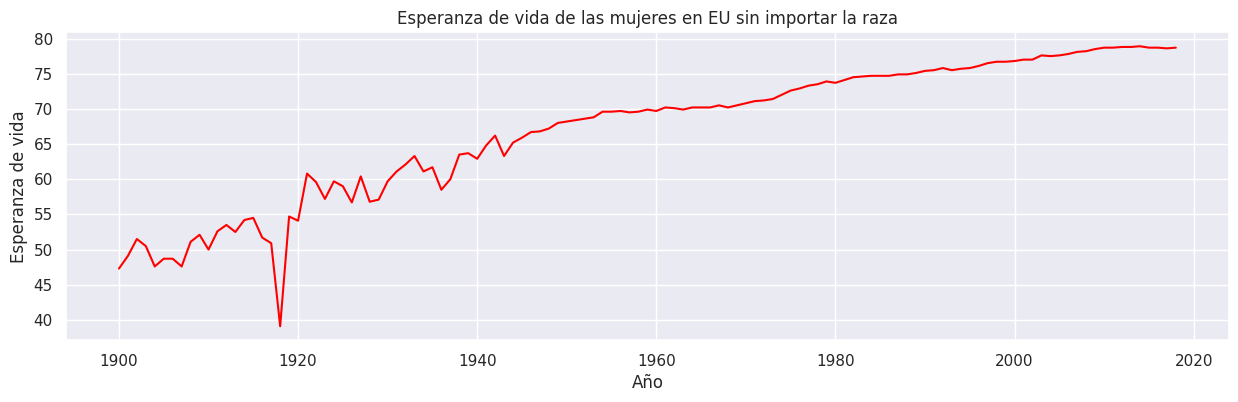

In [10]:
import matplotlib.pyplot as plt

plt.figure (figsize=(15,4), dpi=100)
plt.plot(df['Average Life Expectancy (Years)'], color='red' )
plt.xlabel('Año')
plt.ylabel('Esperanza de vida')
plt.title('Esperanza de vida de las mujeres en EU sin importar la raza')
plt.yscale('linear')

Notemos que en la gráfica existe en los periodos entre 1917-1920 una volatilidad fuerte, así como una tendencia lineal positiva, no se observan periodos estacionales. Como observación, en cuánto más a ido avanzando en el tiempo, la esperanza de vida incrementa, esto puede ser explicado debido a un factor que es el avance en la medicina y la tecnología médica.

Analicemos la Función de Autocorrelación ACF la cual evalúa toda la historia de nuestra serie de tiempo y la Función de Autocorrelación Parcial PACF la cual mide el peso o el impacto que tiene cada momento. Para con ello poder notar que rezagos son importantes, si existe variación estacional, en caso de que exista poder contemplar un modelo estacional y dar una interpretación lógica.

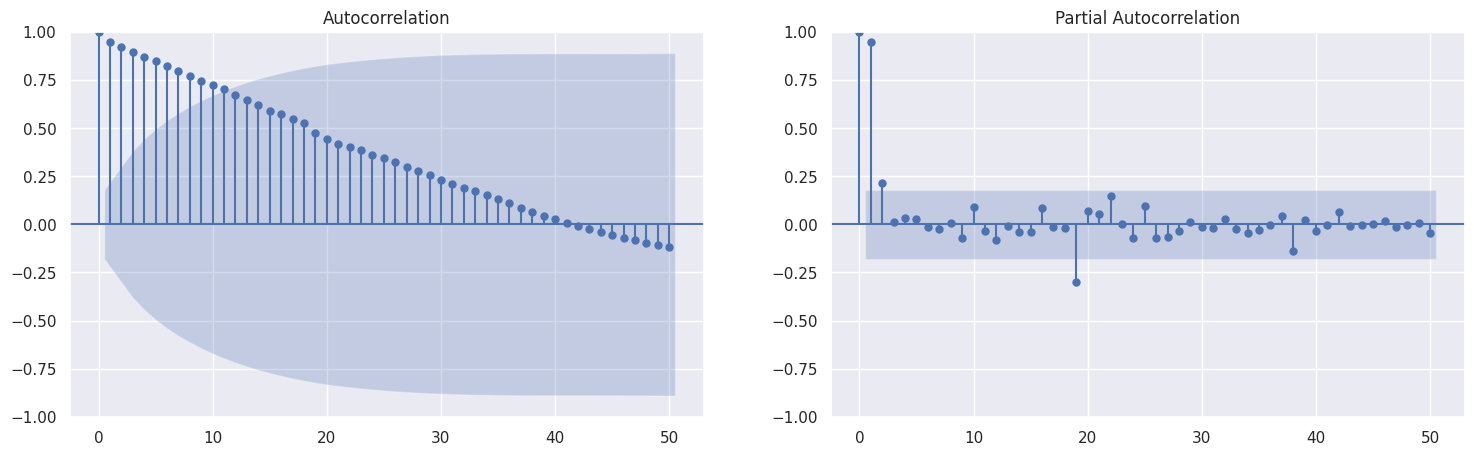

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(18,5), dpi= 100)
plot_acf(df['Average Life Expectancy (Years)'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Average Life Expectancy (Years)'].tolist(), lags=50, ax=axes[1]);

1. ACF: decae rápidamente


2. PACF: los primeros dos retardos son significativos

Prueba de Dickey-Fuller asume que H_0:Not stationarity vs H_1:stationarity. Recordemos que el p-value asume verdadera la hipótesis nula, por tanto, para un alpha significativa del 1% (restrictivos) queremos que el p-value<alpha=0.01, es decir, queremos que el p-value sea muy pequeño posible para rechazar la hipótesis nula y aceptar que la serie es estacionaria (H1 verdadera).

In [12]:
def test_p_value(data):
  fuller_test=adfuller(data)
  print('P-value',fuller_test[1])
  print('*------------------------------------------------------*')
  if fuller_test[1]<0.01:
    print('rechazar hipotesis nula, los datos son estacionarios')
  else:
    print('no rechazar la hipotesis nula, los datos no son estacionarios')

In [13]:
test_p_value(df['Average Life Expectancy (Years)'].dropna())

P-value 0.010835604180626691
*------------------------------------------------------*
no rechazar la hipotesis nula, los datos no son estacionarios


Dado que la serie de tiempo no es estacionaria, y notamos volatilidad y tendencia lineal positiva apliquemos transformaciones (log, 1/log) para ver que transformación elimina la volatilidad de la serie y una diferencia para eliminar la tendencia de la serie y apliquemos Dickey-Fuller.

Como observación es importante primero trabajar con la heteroscedasticidad debido a que es engañosa, es decir, si primero trabajamos con la tendencia lineal puede pasar que la varianza no se estabilice.

In [14]:
# Aplicar el logaritmo natural a la columna con la primera diferencia
df['log_AvrgLife'] = np.log(df['Average Life Expectancy (Years)'])

# Mostrar las primeras filas del nuevo DataFrame con las transformaciones aplicadas
print(df.head())

            Average Life Expectancy (Years)  log_AvrgLife
Year                                                     
1900-01-01                             47.3      3.856510
1901-01-01                             49.1      3.893859
1902-01-01                             51.5      3.941582
1903-01-01                             50.5      3.921973
1904-01-01                             47.6      3.862833


In [15]:
# Calcular la primera diferencia
df['diff_log_AvrgLife'] = df['log_AvrgLife'].diff()

# Mostrar las primeras filas del nuevo DataFrame con las transformaciones aplicadas
print(df.head())

            Average Life Expectancy (Years)  log_AvrgLife  diff_log_AvrgLife
Year                                                                        
1900-01-01                             47.3      3.856510                NaN
1901-01-01                             49.1      3.893859           0.037349
1902-01-01                             51.5      3.941582           0.047723
1903-01-01                             50.5      3.921973          -0.019608
1904-01-01                             47.6      3.862833          -0.059141


Notemos que al aplicar diferencias para eliminar la tendencia se pierde una observación, es por ello que aparece NaN en el año 1900

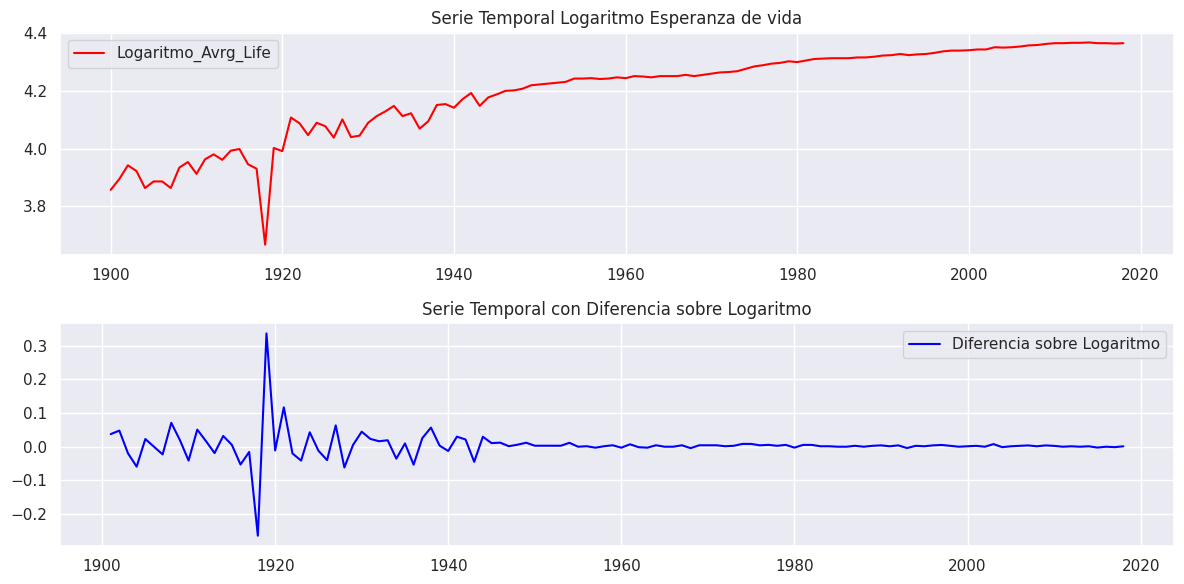

In [16]:
#Si tu serie ya está en un DataFrame, la extraes así:
serie_temporal=df['log_AvrgLife'].dropna()

#Eliminar NaN generados por la diferencia estacional
diferencia_serie_temporal=df['diff_log_AvrgLife'].dropna()

#Graficar la serie original y la diferencia estacional
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(serie_temporal, label='Logaritmo_Avrg_Life',color='red')
plt.title('Serie Temporal Logaritmo Esperanza de vida')
plt.legend()

plt.subplot(2,1,2)
plt.plot(diferencia_serie_temporal, label='Diferencia sobre Logaritmo',color='blue')
plt.title('Serie Temporal con Diferencia sobre Logaritmo')
plt.legend()

plt.tight_layout()
plt.show()

En la gráfica podemos notar que la serie de tiempo ya está estacionarizada, es decir, eliminamos la heteroscedasticidad y la tendencia. Por tanto decidimos trabajar con está serie estacionarizada ya que la volatilidad es más pequeña que va de -0.03 a 0.3 aproximadamente.


Apliquemos Dickey-Fuller para ver si la serie de tiempo es estacionaria, para este caso ya no somos tan restrictivos al definir un nivel de confianza del 90% puesto que aplicamos transformaciones y diferencias, ie, perturbamos la data original, entonces para un alpha del 10% queremos que el p-value<alpha=0.1

In [17]:
def test_p_value(data):
  fuller_test=adfuller(data)
  print('P-value',fuller_test[1])
  print('*------------------------------------------------------*')
  if fuller_test[1]<0.1:
    print('rechazar hipotesis nula, los datos son estacionarios')
  else:
    print('no rechazar la hipotesis nula, los datos no son estacionarios')

In [18]:
test_p_value(df['diff_log_AvrgLife'].dropna())

P-value 0.09456433339334996
*------------------------------------------------------*
rechazar hipotesis nula, los datos son estacionarios


Analicemos la ACF y PACF de la serie estacionarizada

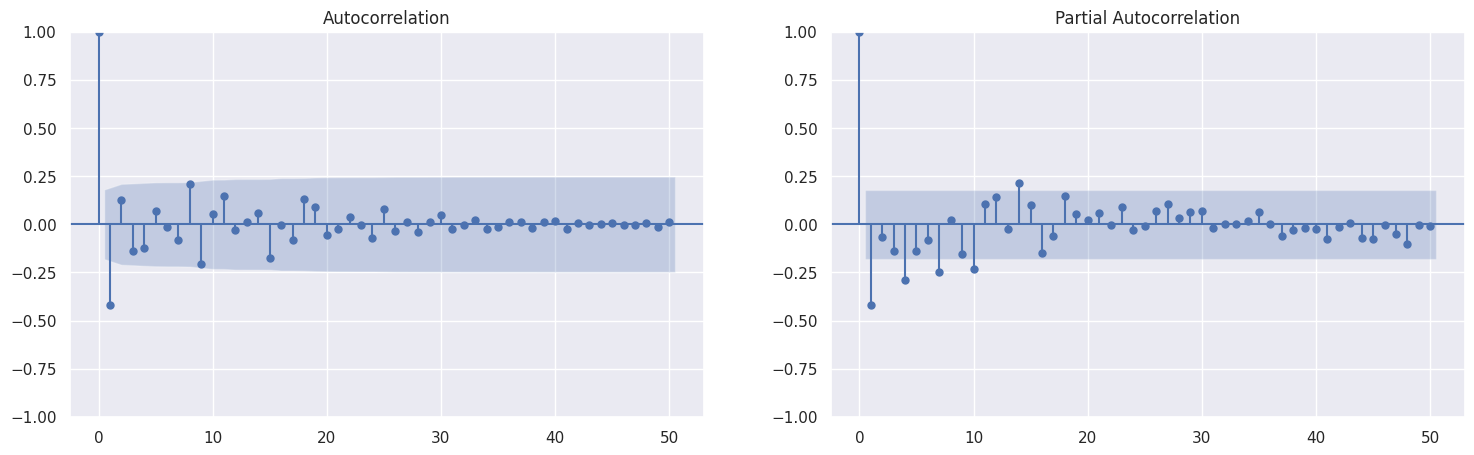

In [19]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(18,5), dpi= 100)
plot_acf(diferencia_serie_temporal.tolist(), lags=50, ax=axes[0])  #tolist() los datos los convierte a una lista
plot_pacf(diferencia_serie_temporal.tolist(), lags=50, ax=axes[1]);

En la ACF podemos observar que los raezagos 1 y 2 muestran una fuerte correlación con la serie, podríamos proponer un modelo $MA(1)$ o $MA(2)$

Y en la PACF podemos observar que los raezagos 1 y 2 muestran una fuerte correlación con la serie, podríamos proponer un modelo $AR(1)$ o $AR(2)$

**Identificación de los parámetros del modelo, una opción es:**

**Parte regular:**

En ambas gráficas no se anulan bruscamnete con periodicidades, es decir,

ACF: decae rápidamente y sinusoidemente y PACF: sólo un coeficiente es significativo; $AR(p=1)$

ACF: dsólo el primero es significativo y PACF: decae rápidamente; $MA(q=1)$

**Parte estacional:**

ACF: decae en forma de ábanico o ábanico-sinosoidal (primer retardo es significativo); $AR(0)$ o $AR(1)$

PACF: sólo el primer retardo es significativo y hay un segundo coeficiente de la autocorrelación parcial correspondiente al segundo periodo estacional "intenta" ser significativo; $MA(1)$

###Estimación

ESTIMACIÓN


$ARIMA (p _{(PACF)},d,q _{(ACF)}) $

Modelo a estimar

1. $ARIMA (1, 1, 1) $

In [20]:
ARIMA_model=ARIMA(diferencia_serie_temporal, order=(1,0,1))
ARIMA_model=ARIMA_model.fit()
print(ARIMA_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      diff_log_AvrgLife   No. Observations:                  118
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 213.680
Date:                Mon, 18 Nov 2024   AIC                           -419.361
Time:                        23:17:20   BIC                           -408.278
Sample:                    01-01-1901   HQIC                          -414.861
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.579      0.000       0.002       0.007
ar.L1          0.2534      0.085      2.988      0.003       0.087       0.420
ma.L1         -0.8201      0.087     -9.406      0.0

Notemos que en el modelo ARIMA no contemplamos una diferencia en los parámetros, debido a que estamos aplicando el SARIMAX  a la serie de tiempo diferenciada (diferencia_serie_temporal), es decir, si agregamos el parámetro de integración, quiere decir que estamos aplicando una diferencia más a la serie perturbada lo cuál es incorrecto.

Realizamos un Sarimax Results para ver que tal estaba nuestro modelo ARIMA (1,1,1), revisando la sobre especificación (que el modelo tenga más parámetros de los necesarios) del modelo a través de pruebas de hipótesis como lo son la prueba T que asume, Ho:parámetro=0 vs H1:parámetro>0, es decir, que la prueba T nos sirve para identificar si los parámetros son significativos o no, por tanto queremos que el p-value<alpha=0.05 para con ello rechazar la hipótesis nula y aceptar que nuestro parámetro es significativo.
Notemos que tanto el parámetro AR(1) autorregresivo de orden 1 tiene un p-value del 0.003 es significativo, y el parámetro MA(1) tiene un p-value del 0.000 lo que también resulta significativo. Por tanto podemos decir que el modelo ARIMA (1,1,1) es adecuado.
Por otra parte, para poder ver si el modelo está sub especificado, vemos en el summary que para la prueba de LJung-Box la cual asume, Ho:WN (White Noise o Ruido blanco) vs H1:Not WN, dónde en está prueba se nos indica que el p-value debe de ser muy grande para aceptar ruido blanco sobre las perturbaciones o los choques aleatorios para el modelo ARIMA (1,1,1), lo cual el p-value para la prueba es alto, ya que tiene una probabilidad de 0.76, por tanto asumimos que para este modelo propuesto los choques aleatorios se comportan como Ruido Blanco. Esto significa que nuestro modelo es útil para realizar el prónostico.

MODELO MATEMÁTICO AJUSTADO

La serie original $Y_t$ se le aplicó $log(Y_t)=X_t$

El modelo que se ha estimado es:

$$ARIMA(1,1,1)$$

que se traduce a la siguiente ecuación:

$$log(X_t)-log(X_{t-1})=\psi (log (X_{t-1})- log (X_{t-2})) + \theta e_{t-1} + e_{t}$$

El término $AR(1)=\psi=0.2534$ que se expresa como:

$$0.2534(log (X_{t-1}) - log (X_{t-2}))$$

El término $MA(1)=\theta=-0.8201$ que se expresa como:

$$-0.8201*e_{t-1}$$

Por lo tanto, el modelo es:

$$log(X_t)-log(X_{t-1})=0.2534 (log (X_{t-1})- log (X_{t-2})) -0.8201 e_{t-1} + e_{t}$$

y $e_{t}\sim N(0,0.0016)$, finalmente reorganizando la ecuación (original):

$$log\left( \frac{X_{t}}{X_{t-1}} \right)= 0.2534*log\left( \frac{X_{t-1}}{X_{t-2}} \right)-0.8201*e_{t-1} + e_{t}$$

$$ \frac{X_{t}}{X_{t-1}}=exp\left(0.2534*log\left( \frac{X_{t-1}}{X_{t-2}} \right)-0.8201*e_{t-1} + e_{t}\right)$$

$$ X_{t}=X_{t-1}*exp\left(0.2534*log\left( \frac{X_{t-1}}{X_{t-2}} \right)-0.8201*e_{t-1} + e_{t}\right)$$

###Análisis de los Residuos

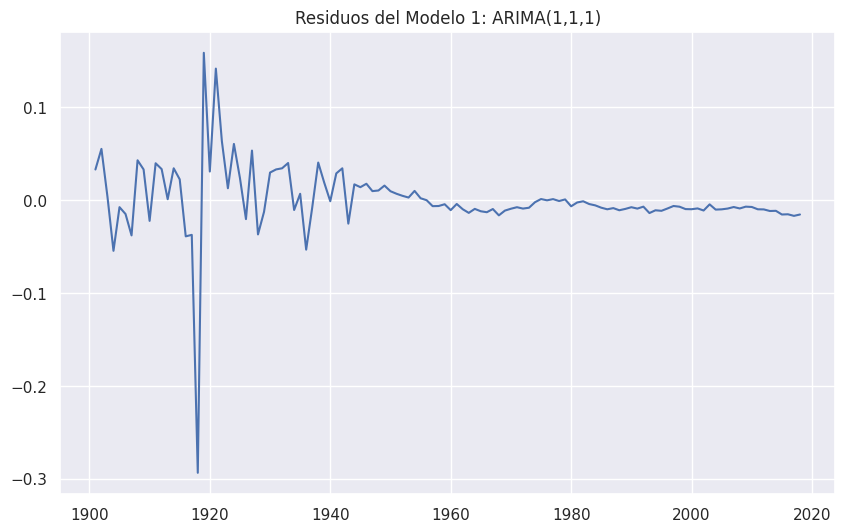

NormaltestResult(statistic=104.81982219816786, pvalue=1.7324663685118352e-23)


In [21]:
residuos = ARIMA_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuos)
plt.title('Residuos del Modelo 1: ARIMA(1,1,1)')
plt.show()

# Test de normalidad de los residuos
from scipy.stats import normaltest
print(normaltest(residuos))

Un p-value bajo como este (muy cercano a cero) indica que rechazamos la hipótesis nula de que los datos siguen una distribución normal.
En este caso, dado que el p-value es muy pequeño, podemos concluir con mucha confianza que los datos no siguen una distribución normal.
Como nuestros datos no siguen una distribución normal, podemos transformar los datos mediante una transformación logarítmica o de Box-Cox para que se ajusten mejor a una distribución normal.
Como nota importante recordemos que nuestro modelo ARIMA (AutoRegressive Integrated Moving Average), asume en sus hipótesis que los errores son normales.Si los residuos no son normales, los estimadores de los parámetros pueden volverse ineficientes, afectando la precisión de las predicciones.

####BOX-COX sobre los residuos

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Valor de lambda: 4.291340136048606
Residuos Box-Cox transformados: [0.55066322 0.60852204 0.47913297 0.35159449 0.45290354 0.43616435
 0.38592681 0.57610001 0.55076193 0.41972098]...


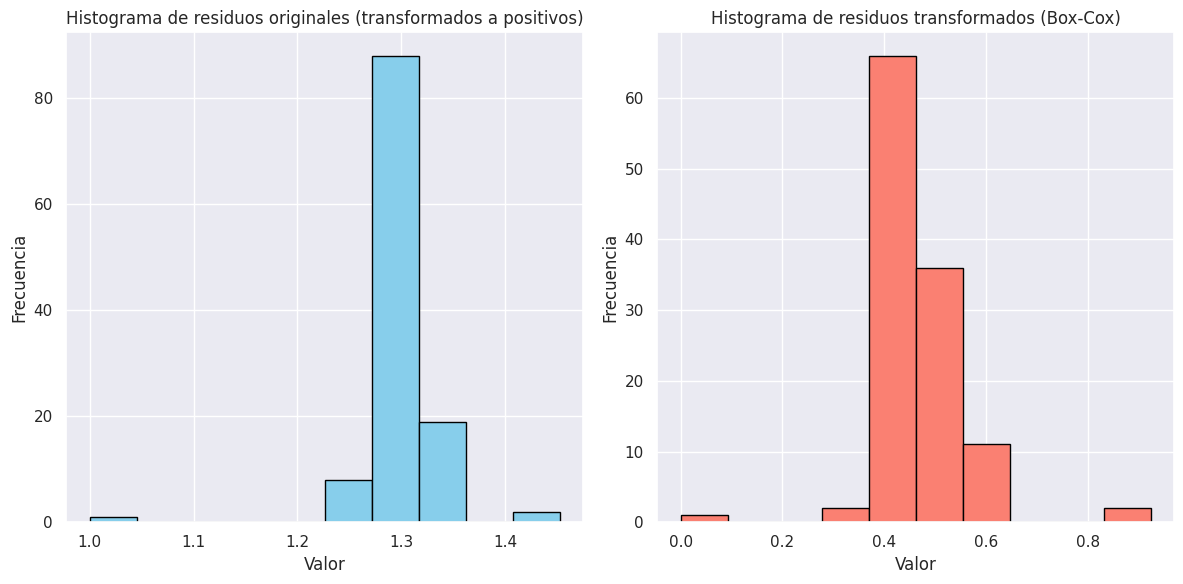

Estadístico de prueba: 49.583256126445306
Valor p: 1.7105380321524657e-11
Los residuos transformados no siguen una distribución normal (rechazo H₀).


In [22]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(diferencia_serie_temporal, order=(1,0,1))
fitted_model = model.fit()

# Obtener los residuos del modelo ajustado
residuos = fitted_model.resid

# Aplicar la transformación Box-Cox a los residuos
# Asegurarse de que los residuos sean positivos, Box-Cox solo funciona con datos positivos
# Si es necesario, se realiza una transformación para hacer que los residuos sean positivos
residuos_positivos = residuos - min(residuos) + 1  # Para hacer que todos los valores sean positivos

# Aplicar Box-Cox
residuos_boxcox, lambda_ = stats.boxcox(residuos_positivos)

# Imprimir resultados
print(f"Valor de lambda: {lambda_}")
print(f"Residuos Box-Cox transformados: {residuos_boxcox[:10]}...")  # Imprimir solo los primeros 10 valores

# Visualizar los resultados
plt.figure(figsize=(12, 6))

# Graficar los residuos originales
plt.subplot(1, 2, 1)
plt.hist(residuos_positivos, bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de residuos originales (transformados a positivos)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Graficar los residuos transformados
plt.subplot(1, 2, 2)
plt.hist(residuos_boxcox, bins=10, color='salmon', edgecolor='black')
plt.title('Histograma de residuos transformados (Box-Cox)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Realizar una prueba de normalidad sobre los residuos Box-Cox (opcional)
stat, p_value = stats.normaltest(residuos_boxcox)

# Interpretación
print(f"Estadístico de prueba: {stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Los residuos transformados no siguen una distribución normal (rechazo H₀).")
else:
    print("Los residuos transformados siguen una distribución normal (no se rechaza H₀).")

Notemos que a pesar de que la prueba de BOX-COX no nos afirma que los residuos transformados no siguien una distribución normal, gráficamente y no siendo tan restrictivos si siguien una distribución normal. Al acotar nuestra serie de tiempo perdímos información esencial por tanto nuestros residuos "no siguien una distribución normal", por tanto en nuestro análisis podemos aceptar la no normalidad de nuestros choques aleatorios.

####RMSE (Error Cuadrático Medio de la Raíz) y Pronóstico

In [23]:
predictions=ARIMA_model.get_forecast(len(df['log_AvrgLife']))
predictions_df=predictions.conf_int(alpha=0.05)
predictions_df['predictions']=ARIMA_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
predictions_df.index=df['log_AvrgLife']
predictions_arma=predictions_df['predictions']
predictions_arma

print(predictions_arma.values[0:14])

[0.01606776 0.00722809 0.00498837 0.00442089 0.00427711 0.00424068
 0.00423145 0.00422911 0.00422851 0.00422836 0.00422833 0.00422832
 0.00422831 0.00422831]


In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse=np.sqrt(mean_squared_error(df['log_AvrgLife'].values, predictions_df['predictions']))
print(rmse)

4.19107993902919


**Pronóstico dentro de la Serie de Tiempo**

Year
1901-01-01    0.004228
1902-01-01   -0.007601
1903-01-01   -0.023469
1904-01-01   -0.004693
1905-01-01    0.030282
                ...   
2014-01-01    0.012649
2015-01-01    0.012811
2016-01-01    0.015101
2017-01-01    0.015541
2018-01-01    0.016622
Length: 118, dtype: float64


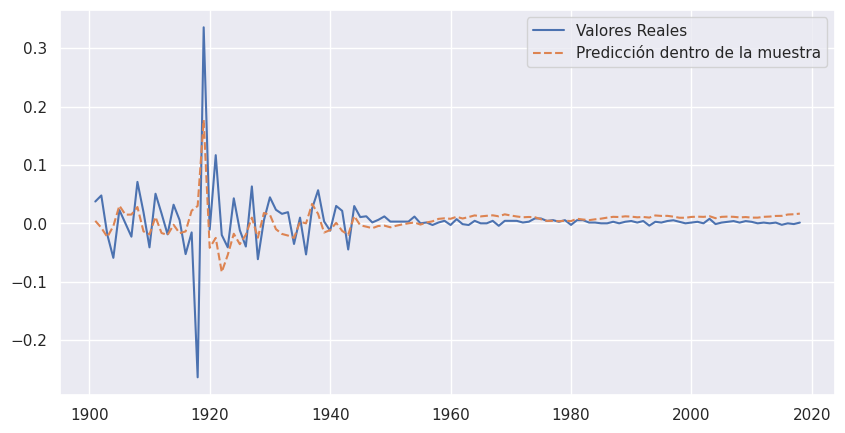

In [25]:
#Predicción dentro de la muestra
in_sample_forecast=ARIMA_model.fittedvalues

#Puedes imprimir los valores para verlos
print(in_sample_forecast)

#Tambien puedes comparar con  los valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(diferencia_serie_temporal, label='Valores Reales')
plt.plot(in_sample_forecast, label='Predicción dentro de la muestra',linestyle='--')
plt.legend()
plt.show()

**Pronóstico fuera de la Serie de Tiempo**

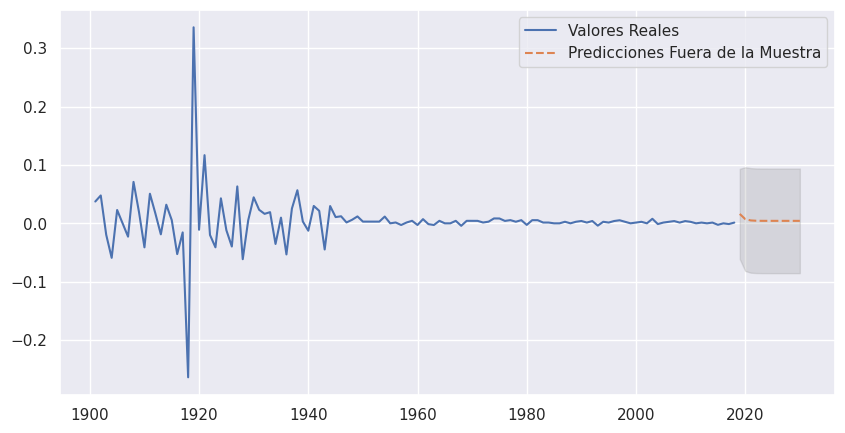

In [26]:
# Especifica el número de períodos que deseas predecir
num_periods = 12  # Por ejemplo, predice 12 períodos hacia adelante

# Realizar la predicción fuera de la muestra
out_of_sample_forecast = ARIMA_model.get_forecast(steps=num_periods)

# Obtén las predicciones en forma de serie temporal
forecast_values = out_of_sample_forecast.predicted_mean

# Obtén el intervalo de confianza de las predicciones
conf_int = out_of_sample_forecast.conf_int()

# Visualización de la predicción fuera de la muestra
plt.figure(figsize=(10,5))
plt.plot(diferencia_serie_temporal, label='Valores Reales')
plt.plot(forecast_values, label='Predicciones Fuera de la Muestra', linestyle='--')
plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)

plt.legend()
plt.show()

**RMSE dentro de la muestra**

In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Valores reales dentro de la muestra
actual_values_in_sample =diferencia_serie_temporal

# Valores predichos dentro de la muestra
predicted_values_in_sample = ARIMA_model.fittedvalues

# Calcular el RMSE dentro de la muestra
rmse_in_sample = np.sqrt(mean_squared_error(actual_values_in_sample, predicted_values_in_sample))

print(f"RMSE dentro de la muestra: {rmse_in_sample}")

RMSE dentro de la muestra: 0.03955222029560902


**RMSE fuera de la muestra**

In [28]:
#Si estamos prediciendo 12 períodos hacia adelante, necesitas tener esos valores:
actual_values_out_of_sample = forecast_values  # Reemplaza con los valores reales futuros

# Valores predichos fuera de la muestra
predicted_values_out_of_sample = forecast_values  # De la predicción fuera de la muestra

# Calcular el RMSE fuera de la muestra
rmse_out_of_sample = np.sqrt(mean_squared_error(actual_values_out_of_sample, predicted_values_out_of_sample))

print(f"RMSE fuera de la muestra: {rmse_out_of_sample}")

RMSE fuera de la muestra: 0.0


Esto generalmente indica que el modelo está realizando predicciones perfectamente precisas para el conjunto de prueba.

**FIN METODOLOGÍA BOX-JENKINS**